In [1]:
import json
import urllib
import http.cookiejar
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import numpy as np


pd.set_option('display.max_rows', None)

In [ ]:
my_moex_login = 'email@mailserver.com'
my_moex_password = '******************'

classes are taken from here:
https://www.moex.com/a2193

In [2]:
class Config:
    def __init__(self, user='', password='', proxy_url=''):
        """ user: username in MOEX Passport to access real-time data and history
            password: password for this user
            proxy_url: proxy URL if any is used, specified as http://proxy:port
        """  
        self.proxy_url = proxy_url
        self.user = user
        self.password = password
        self.auth_url = "https://passport.moex.com/login"

        
class MicexAuth:

    def __init__(self, config):
        self.config = config
        self.cookie_jar = http.cookiejar.CookieJar()
        self.passport = None
        self.auth()

    def auth(self):
        if self.config.proxy_url:
            opener = urllib.request.build_opener(urllib.request.ProxyHandler({'http': self.config.proxy_url}),
                                                 urllib.request.HTTPCookieProcessor(self.cookie_jar),
                                                 urllib.request.HTTPHandler(debuglevel=0))
        else:
            opener = urllib.request.build_opener(urllib.request.HTTPCookieProcessor(self.cookie_jar),
                                                 urllib.request.HTTPHandler(debuglevel=0))
        opener.addheaders = [('Authorization',
                              'Basic %s' % (self.config.user + ':' + self.config.password)[:-1])]
        opener.open(self.config.auth_url)

        # we only need a cookie with MOEX Passport (certificate)
        self.passport = None
        for cookie in self.cookie_jar:
            if cookie.name == '_passport_session':
                self.passport = cookie
                break
        else:
            print('Cookie not found!')

    def is_real_time(self):
        if not self.passport or (self.passport and self.passport.is_expired()):
            self.auth()
        if self.passport and not self.passport.is_expired():
            return True
        return False   
    
    
class MicexISSClient:

    def __init__(self, config, auth):
        """ Create opener for a connection with authorization cookie.
            It's not possible to reuse the opener used to authenticate because
            there's no method in opener to remove auth data.
            config: instance of the Config class with configuration options
            auth: instance of the MicexAuth class with authentication info
            handler: user's handler class inherited from MicexISSDataHandler
            containet: user's container class
        """
        self.config = config
        self.opener = None
        self.results = None
        self.auth = auth

        if self.config.proxy_url:
            self.opener = urllib.request.build_opener(urllib.request.ProxyHandler({'http': self.config.proxy_url}),
                                                      urllib.request.HTTPCookieProcessor(self.auth.cookie_jar),
                                                      urllib.request.HTTPHandler(debuglevel=0))
        else:
            self.opener = urllib.request.build_opener(urllib.request.HTTPCookieProcessor(self.auth.cookie_jar),
                                                      urllib.request.HTTPHandler(debuglevel=0))
        urllib.request.install_opener(self.opener)

    def get_brd_hist_date(self, date, engine='stock', market='shares', board='TQBR'):
        """ http://iss.moex.com/iss/reference/
        
            /iss/history/engines/[engine]/markets/[market]/boards/[board]/securities
            Получить историю торгов для всех бумаг на указанном режиме торгов отфильтрованных по дате.
        """
        self.results = None
        url = (
            f'http://iss.moex.com/iss/history/engines/'
            f'{engine}/markets/{market}/boards/{board}/'
            f'securities.json?date={date}&iss.meta=off'
        )
        print(url)
        # always remember about the 'start' argument to get long replies
        start = 0
        results = []
        while True:
            res = json.load(self.opener.open(url + '&start=' + str(start)))
            history = res['history']
            data = history['data']
            cols = history['columns']
            results.extend(data)
            start += len(data)
            if not len(data): break
            
        self.results = pd.DataFrame(results, columns=cols)
        return True
    
    def get_share_hist_dates(self, security, start_date, end_date=None, engine='stock', market='shares'):
        """ http://iss.moex.com/iss/reference/
        
            /iss/history/engines/[engine]/markets/[market]/securities/[security]
            Получить историю по одной бумаге на рынке за интервал дат..
        """
        if end_date is None:
            end_date = datetime.today() - timedelta(days=2)
            end_date = end_date.strftime('%Y-%m-%d')
            
        self.results = None
        url = (
            f'http://iss.moex.com/iss/history/engines/'
            f'{engine}/markets/{market}//securities/{security}/'
            f'securities.json?iss.meta=off&from={start_date}&till={end_date}'
        )
        print(url)
        # always remember about the 'start' argument to get long replies
        start = 0
        results = []
        while True:
            res = json.load(self.opener.open(url + '&start=' + str(start)))
            history = res['history']
            data = history['data']
            cols = history['columns']
            results.extend(data)
            start += len(data)
            if not len(data): break
            
        self.results = pd.DataFrame(results, columns=cols)
        self.results = self.results[self.results['LEGALCLOSEPRICE'].notna()]
        selected_cols = ['TRADEDATE', 'NUMTRADES', 'VALUE', 'OPEN', 'LOW', 'HIGH', 'LEGALCLOSEPRICE', 'CLOSE', 'VOLUME']
        self.results = self.results[selected_cols]
        return True    

In [3]:
my_config = Config(user=my_moex_login, password=my_moex_password, proxy_url='')
my_auth = MicexAuth(my_config)
if my_auth.is_real_time():
    iss = MicexISSClient(my_config, my_auth)
    iss.get_brd_hist_date('2010-04-29', board='eqne')
iss.results

http://iss.moex.com/iss/history/engines/stock/markets/shares/boards/eqne/securities.json?date=2010-04-29&iss.meta=off


,BOARDID,TRADEDATE,SHORTNAME,SECID,NUMTRADES,VALUE,OPEN,LOW,HIGH,LEGALCLOSEPRICE,...,CLOSE,VOLUME,MARKETPRICE2,MARKETPRICE3,ADMITTEDQUOTE,MP2VALTRD,MARKETPRICE3TRADESVALUE,ADMITTEDVALUE,WAVAL,TRADINGSESSION
0,EQNE,2010-04-29,АшинскийМЗ,AMEZ,73,7.761018e+05,13.4200,13.2000,13.9500,1.357100e+01,...,13.5710,56700,13.6880,None,13.6880,7.761018e+05,None,7.761018e+05,None,3
1,EQNE,2010-04-29,Армада,ARMD,112,1.482698e+06,254.1000,253.9900,260.3000,2.548300e+02,...,254.7100,5816,254.9300,None,254.9300,1.482698e+06,None,1.482698e+06,None,3
2,EQNE,2010-04-29,Арсагера,ARSA,107,4.201260e+05,2.6450,2.6400,2.7290,2.710000e+00,...,2.7100,156400,NaN,None,NaN,0.000000e+00,None,0.000000e+00,None,3
3,EQNE,2010-04-29,АстрЭнСб,ASSB,4,1.442700e+05,0.9700,0.9500,0.9700,9.550000e-01,...,0.9570,151000,0.9390,None,0.9390,1.371433e+06,None,1.371433e+06,None,3
4,EQNE,2010-04-29,Азот ао,AZKM,36,1.231485e+05,441.0900,405.5500,449.0000,4.461700e+02,...,448.8900,289,NaN,None,NaN,0.000000e+00,None,0.000000e+00,None,3
5,EQNE,2010-04-29,"ОАО ""БизнесАктив""",BACT,23,2.416180e+04,1.1990,1.1510,1.2490,1.241000e+00,...,1.2490,20500,NaN,None,NaN,0.000000e+00,None,0.000000e+00,None,3
6,EQNE,2010-04-29,БашЭнрг ао,BEGY,128,1.813546e+06,49.0000,47.0800,49.0000,4.880000e+01,...,48.8600,37695,48.1100,None,48.1100,1.813546e+06,None,1.813546e+06,None,3
7,EQNE,2010-04-29,"ОАО ""КорСсис""",BENR,1,6.249500e+02,624.9500,624.9500,624.9500,6.249500e+02,...,624.9500,1,NaN,None,NaN,0.000000e+00,None,0.000000e+00,None,3
8,EQNE,2010-04-29,"ОАО ""КорСсис""",BENRP,0,0.000000e+00,NaN,NaN,NaN,4.360800e+02,...,NaN,0,NaN,None,NaN,0.000000e+00,None,0.000000e+00,None,3
9,EQNE,2010-04-29,БашИнСв ао,BISV,13,5.269380e+04,4.0050,4.0050,4.2990,4.298000e+00,...,4.2990,12300,NaN,None,NaN,0.000000e+00,None,0.000000e+00,None,3


In [4]:
my_config = Config(user=my_moex_login, password=my_moex_password, proxy_url='')
my_auth = MicexAuth(my_config)
if my_auth.is_real_time():
    iss = MicexISSClient(my_config, my_auth)
    iss.get_share_hist_dates('GAZP', '2020-10-30')  

http://iss.moex.com/iss/history/engines/stock/markets/shares//securities/GAZP/securities.json?iss.meta=off&from=2020-10-30&till=2021-07-31


In [5]:
# pd.set_option('display.max_rows', 20)
# print(iss.results)
# pd.set_option('display.max_rows', None)
iss.results

,TRADEDATE,NUMTRADES,VALUE,OPEN,LOW,HIGH,LEGALCLOSEPRICE,CLOSE,VOLUME
1,2020-10-30,69821,6.629759e+09,155.00,154.08,156.20,155.00,154.28,42721140
3,2020-11-02,86434,1.082034e+10,153.98,151.90,157.98,156.59,157.74,69727760
5,2020-11-03,92935,1.140882e+10,158.21,157.44,161.92,160.59,161.09,71122150
7,2020-11-05,98747,1.200134e+10,163.80,161.99,165.25,164.59,163.70,73279220
9,2020-11-06,75381,8.455052e+09,163.00,161.52,165.84,165.27,164.92,51681030
11,2020-11-09,149339,1.745805e+10,166.72,164.90,171.50,171.50,170.13,103450630
13,2020-11-10,114567,1.312153e+10,169.03,167.63,173.64,172.76,172.92,76691660
15,2020-11-11,96880,1.246529e+10,173.50,170.26,175.15,171.86,170.53,72044740
17,2020-11-12,100136,1.247776e+10,170.00,169.75,175.30,174.30,172.91,71999190
19,2020-11-13,148342,1.864110e+10,172.90,172.42,181.27,179.50,180.30,104617540


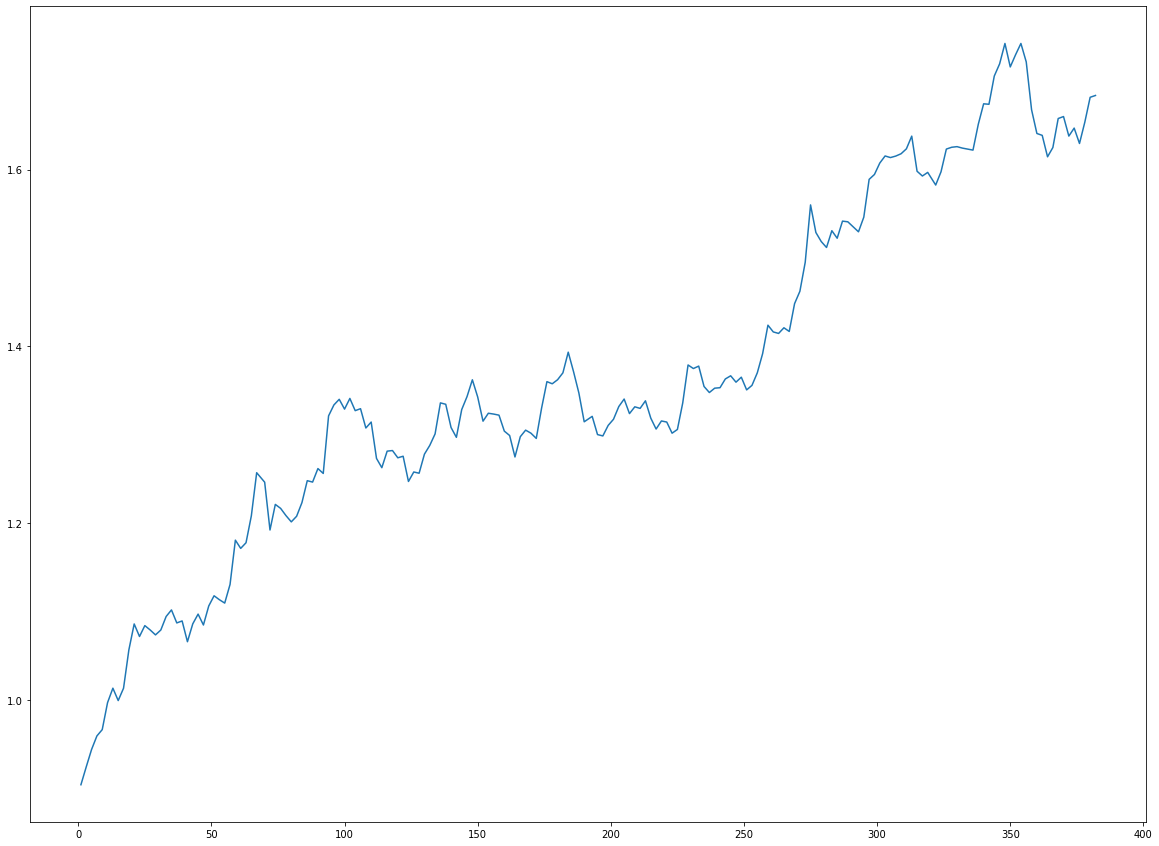

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
ax.plot(iss.results['CLOSE'] / 170.66)

In [73]:
moex_prefix = 'http://iss.moex.com/iss/'
index_postfix = 'index.json?iss.meta=off'
index_url = moex_prefix + index_postfix
response = urllib.request.urlopen(index_url)
moex_index = json.loads(response.read())

In [74]:
moex_index

{'engines': {'columns': ['id', 'name', 'title'],
  'data': [[1, 'stock', 'Фондовый рынок и рынок депозитов'],
   [2, 'state', 'Рынок ГЦБ (размещение)'],
   [3, 'currency', 'Валютный рынок'],
   [4, 'futures', 'Срочный рынок'],
   [5, 'commodity', 'Товарный рынок'],
   [6, 'interventions', 'Товарные интервенции'],
   [7, 'offboard', 'ОТС-система'],
   [9, 'agro', 'Агро']]},
 'markets': {'columns': ['id',
   'trade_engine_id',
   'trade_engine_name',
   'trade_engine_title',
   'market_name',
   'market_title',
   'market_id',
   'marketplace'],
  'data': [[51, 9, 'agro', 'Агро', 'sugar', 'Торги сахаром', 51, None],
   [5,
    1,
    'stock',
    'Фондовый рынок и рынок депозитов',
    'index',
    'Индексы фондового рынка',
    5,
    'INDICES'],
   [1,
    1,
    'stock',
    'Фондовый рынок и рынок депозитов',
    'shares',
    'Рынок акций',
    1,
    'MXSE'],
   [2,
    1,
    'stock',
    'Фондовый рынок и рынок депозитов',
    'bonds',
    'Рынок облигаций',
    2,
    'MXSE'],
 

In [79]:
moex_keys = list(moex_index.keys())
moex_keys

['engines',
 'markets',
 'boards',
 'boardgroups',
 'durations',
 'securitytypes',
 'securitygroups',
 'securitycollections']

In [80]:
moex_index[moex_keys[0]]

{'columns': ['id', 'name', 'title'],
 'data': [[1, 'stock', 'Фондовый рынок и рынок депозитов'],
  [2, 'state', 'Рынок ГЦБ (размещение)'],
  [3, 'currency', 'Валютный рынок'],
  [4, 'futures', 'Срочный рынок'],
  [5, 'commodity', 'Товарный рынок'],
  [6, 'interventions', 'Товарные интервенции'],
  [7, 'offboard', 'ОТС-система'],
  [9, 'agro', 'Агро']]}

In [81]:
engines_df = pd.DataFrame(moex_index['engines']['data'], columns=moex_index['engines']['columns'])
engines_df.sort_values(by=['id'])

,id,name,title
0,1,stock,Фондовый рынок и рынок депозитов
1,2,state,Рынок ГЦБ (размещение)
2,3,currency,Валютный рынок
3,4,futures,Срочный рынок
4,5,commodity,Товарный рынок
5,6,interventions,Товарные интервенции
6,7,offboard,ОТС-система
7,9,agro,Агро


In [82]:
markets_df = pd.DataFrame(moex_index['markets']['data'], columns=moex_index['markets']['columns'])
markets_df.sort_values(by=['id'])

,id,trade_engine_id,trade_engine_name,trade_engine_title,market_name,market_title,market_id,marketplace
2,1,1,stock,Фондовый рынок и рынок депозитов,shares,Рынок акций,1,MXSE
3,2,1,stock,Фондовый рынок и рынок депозитов,bonds,Рынок облигаций,2,MXSE
8,3,1,stock,Фондовый рынок и рынок депозитов,repo,Рынок сделок РЕПО,3,None
4,4,1,stock,Фондовый рынок и рынок депозитов,ndm,Режим переговорных сделок,4,None
1,5,1,stock,Фондовый рынок и рынок депозитов,index,Индексы фондового рынка,5,INDICES
27,6,2,state,Рынок ГЦБ (размещение),bonds,Облигации ГЦБ,6,None
28,7,2,state,Рынок ГЦБ (размещение),repo,Междилерское РЕПО,7,None
29,8,2,state,Рынок ГЦБ (размещение),ndm,Внесистемные сделки,8,None
26,9,2,state,Рынок ГЦБ (размещение),index,Индексы ГКО/ОФЗ,9,None
17,10,3,currency,Валютный рынок,selt,Биржевые сделки с ЦК,10,MXCX


In [83]:
boardgroups_df = pd.DataFrame(moex_index['boardgroups']['data'], columns=moex_index['boardgroups']['columns'])
boardgroups_df#.sort_values(by=['id'])

,id,trade_engine_id,trade_engine_name,trade_engine_title,market_id,market_name,name,title,is_default,board_group_id,is_traded
0,9,1,stock,Фондовый рынок и рынок депозитов,5,index,stock_index,Индексы,1,9,1
1,104,1,stock,Фондовый рынок и рынок депозитов,5,index,stock_index_inav,INAV,0,104,1
2,155,1,stock,Фондовый рынок и рынок депозитов,5,index,stock_index_mmix,Money Market IndeX,0,155,1
3,57,1,stock,Фондовый рынок и рынок депозитов,1,shares,stock_shares_tplus,Т+: Основной режим - безадрес.,1,57,1
4,156,1,stock,Фондовый рынок и рынок депозитов,1,shares,stock_shares_tplus_usd,Т+: Основной режим (USD) - безадрес.,0,156,1
...,...,...,...,...,...,...,...,...,...,...,...
163,139,4,futures,Срочный рынок,38,optionsiqs,futures_optionsiqs,Опционы IQS,1,139,1
164,20,5,commodity,Товарный рынок,18,futures,commodity_futures,Стандартные контракты АО НТБ,1,20,0
165,24,6,interventions,Товарные интервенции,20,grain,interventions_grain,Интервенции по продаже зерна,1,24,1
166,141,7,offboard,ОТС-система,39,bonds,offboard_bond_all,ОТС-система: облигации,1,141,1


In [84]:
boardgroups_df['title'].tolist()

['Индексы',
 'INAV',
 'Money Market IndeX',
 'Т+: Основной режим - безадрес.',
 'Т+: Основной режим (USD) - безадрес.',
 'Т0: Основной режим - безадрес.',
 'Поставка по СК',
 'Неполные лоты - безадрес.',
 'Крупные пакеты - безадрес.',
 'Т0 ETF (USD) - безадрес.',
 'Т+: Основной режим (EUR) - безадрес.',
 'Т0 ETF (расч. в EUR) - безадрес.',
 'ЦК - Режим основных торгов - безадрес.',
 'Т+: Основной режим - безадрес.',
 'Т+: Основной режим (USD) - безадрес.',
 'Т+: Основной режим (ЕТС) - безадрес.',
 'Т0: Основной режим - безадрес.',
 'Поставка по СК',
 'Т0: Основной режим (ЕТС) - безадрес.',
 'Т0: Основной режим (Еврооблигации) - безадрес.',
 'Выкуп - безадрес.',
 'Размещение - безадрес.',
 'Крупные пакеты - безадрес.',
 'Т+: Облигации (EUR) - безадрес.',
 'Крупные пакеты – Облигации (USD) - безадрес.',
 'Т+: Облигации (CNY) - безадрес.',
 'Аукцион: адресные заявки',
 'Т+: РПС с ЦК - адрес.',
 'РПС (USD) - адрес.',
 'РПС - адрес.',
 'РПС: В валюте - адрес.',
 'РПС: Размещение - адрес.',


In [134]:
boards_df = pd.DataFrame(moex_index['boards']['data'], columns=moex_index['boards']['columns'])
boards_df.sort_values(by=['id'])

,id,board_group_id,engine_id,market_id,boardid,board_title,is_traded,has_candles,is_primary
14,1,6,1,1,EQBR,Основной режим: А1-Акции и паи - безадрес.,0,1,0
15,2,6,1,1,EQBS,Основной режим: А2-Акции и паи - безадрес.,0,1,0
17,3,6,1,1,EQLV,Основной режим: В-Акции и РДР - безадрес.,0,1,0
16,4,6,1,1,EQNL,Основной режим: Б-Акции и паи - безадрес.,0,1,0
20,5,6,1,1,EQNE,Основной режим: Акции и паи внесписочные - без...,0,1,0
50,6,7,1,2,EQNB,Основной режим: Облигации внесписочные - безад...,0,1,1
47,7,7,1,2,EQNO,Основной режим: Б-Облигации - безадрес.,0,1,1
45,8,7,1,2,EQOB,Т0 Облигации - безадрес.,0,1,1
46,9,7,1,2,EQOS,Основной режим: А2-Облигации - безадрес.,0,1,1
98,11,8,1,4,PSEQ,РПС: Акции - адрес.,1,0,1


In [135]:
boards_df['engine'] = boards_df['engine_id'].apply(lambda x: engines_df[engines_df['id'] == x]['title'].values[0])
boards_df['market'] = boards_df['market_id'].apply(lambda x: markets_df[markets_df['market_id'] == x]['market_title'].values[0])
boards_df['board_group'] = boards_df['board_group_id'].apply(lambda x: boardgroups_df[boardgroups_df['board_group_id'] == x]['title'].values[0])
boards_df = boards_df.drop(columns=['engine_id', 'market_id', 'board_group_id'])
boards_df = boards_df[['engine', 'market', 'board_group', 'board_title', 'boardid', 'id']]
boards_df

,engine,market,board_group,board_title,boardid,id
0,Фондовый рынок и рынок депозитов,Рынок акций,Т+: Основной режим - безадрес.,Т+: Паи - безадрес.,TQIF,177
1,Фондовый рынок и рынок депозитов,Рынок акций,Т+: Основной режим - безадрес.,Т+: ETF - безадрес.,TQTF,178
2,Фондовый рынок и рынок депозитов,Рынок акций,Т+: Основной режим - безадрес.,Т+: Акции и ДР - безадрес.,TQBR,129
3,Фондовый рынок и рынок депозитов,Рынок акций,Т+: Основной режим - безадрес.,Т+: А2-Акции и паи - безадрес.,TQBS,130
4,Фондовый рынок и рынок депозитов,Рынок акций,Т+: Основной режим - безадрес.,Т+: Б-Акции и паи - безадрес.,TQNL,131
5,Фондовый рынок и рынок депозитов,Рынок акций,Т+: Основной режим - безадрес.,Т+: В-Акции и ДР - безадрес.,TQLV,132
6,Фондовый рынок и рынок депозитов,Рынок акций,Т+: Основной режим - безадрес.,Т+: И-Акции - безадрес.,TQLI,133
7,Фондовый рынок и рынок депозитов,Рынок акций,Т+: Основной режим - безадрес.,"Т+: Акции, паи и ДР внесписочные - безадрес.",TQNE,134
8,Фондовый рынок и рынок депозитов,Рынок акций,Т+: Основной режим - безадрес.,Т+: Акции Д - безадрес.,TQDE,158
9,Фондовый рынок и рынок депозитов,Рынок акций,Т+: Основной режим - безадрес.,Т+: Акции ПИР - безадрес.,TQPI,401


In [12]:
security = 'CHMF'
sec_inclusion_url = moex_prefix + f'securities/{security}/indices.json?iss.meta=off'
response = urllib.request.urlopen(sec_inclusion_url)
sec_inclusion = json.loads(response.read())
sec_inclusion = pd.DataFrame(sec_inclusion['indices']['data'], columns=sec_inclusion['indices']['columns'])
sec_inclusion

,SECID,SHORTNAME,FROM,TILL
0,EPSI,Субиндекс акций,2014-09-16,2021-02-08
1,IMOEX,Индекс МосБиржи,2007-04-16,2021-02-08
2,IMOEX2,Индекс МосБиржи (доп. сессия),2020-06-22,2021-02-08
3,MCXSM,Индекс МосБиржи SMID,2014-01-06,2014-12-30
4,MICEXLC,MICEX LC,2007-07-16,2013-05-17
5,MICEXMC,MICEX MC,2005-07-01,2010-04-23
6,MOEX10,Индекс МосБиржи 10,2009-10-02,2012-07-02
7,MOEXBC,Индекс голубых фишек,2010-01-14,2020-03-19
8,MOEXBMI,Индекс широкого рынка,2011-12-30,2021-02-08
9,MOEXMM,Индекс металлов и добычи,2005-07-01,2021-02-08


In [13]:
sec_inclusion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SECID      17 non-null     object
 1   SHORTNAME  17 non-null     object
 2   FROM       17 non-null     object
 3   TILL       17 non-null     object
dtypes: object(4)
memory usage: 672.0+ bytes


In [14]:
from datetime import datetime
date_format = '%Y-%m-%d'


datetime.strptime(sec_inclusion.iloc[10]['TILL'], date_format) > datetime.now()

False

In [15]:
sec_inclusion = sec_inclusion[sec_inclusion['TILL'].apply(lambda x: datetime.strptime(x, date_format).year >= datetime.now().year)]

In [16]:
sec_inclusion

,SECID,SHORTNAME,FROM,TILL
0,EPSI,Субиндекс акций,2014-09-16,2021-02-08
1,IMOEX,Индекс МосБиржи,2007-04-16,2021-02-08
2,IMOEX2,Индекс МосБиржи (доп. сессия),2020-06-22,2021-02-08
8,MOEXBMI,Индекс широкого рынка,2011-12-30,2021-02-08
9,MOEXMM,Индекс металлов и добычи,2005-07-01,2021-02-08
11,MRRT,"Индекс ""Ответственность и открытость""",2020-09-21,2021-02-08
12,MRSV,"Индекс ""Вектор устойчивого развития""",2020-09-21,2021-02-08
13,RTSI,Индекс РТС,2009-09-30,2021-02-08
14,RTSmm,Индекс РТС металлов и добычи,2009-09-30,2021-02-08
16,RUBMI,Индекс РТС широкого рынка,2013-05-20,2021-02-08


In [26]:
engine = 'stock'
market = 'shares'
securities_list_url = moex_prefix + f'engines/{engine}/markets/{market}/securities.json?iss.meta=off'
response = urllib.request.urlopen(securities_list_url)
securities_list = json.loads(response.read())
securities_list_df = pd.DataFrame(securities_list['securities']['data'], columns=securities_list['securities']['columns'])

In [27]:
pd.set_option('display.max_columns', None)
securities_list_df.head()

,SECID,BOARDID,SHORTNAME,PREVPRICE,LOTSIZE,FACEVALUE,STATUS,BOARDNAME,DECIMALS,SECNAME,REMARKS,MARKETCODE,INSTRID,SECTORID,MINSTEP,PREVWAPRICE,FACEUNIT,PREVDATE,ISSUESIZE,ISIN,LATNAME,REGNUMBER,PREVLEGALCLOSEPRICE,PREVADMITTEDQUOTE,CURRENCYID,SECTYPE,LISTLEVEL,SETTLEDATE
0,ABRD,SMAL,АбрауДюрсо,228.50,1,1.00,A,Т+: Неполные лоты (акции) - безадрес.,1,Абрау-Дюрсо ПАО ао,None,FNDT,EQIN,None,0.500,197.500,SUR,2021-02-08,98000184,RU000A0JS5T7,Abrau-Durso ao,1-02-12500-A,NaN,NaN,SUR,1,3,2021-02-11
1,ACKO,SMAL,АСКО ао,5.00,1,1.00,A,Т+: Неполные лоты (акции) - безадрес.,2,АСКО-СТРАХОВАНИЕ ПАО ао,None,FNDT,EQIN,None,0.020,5.860,SUR,2021-02-08,536000000,RU000A0JXS91,ASKO-STRAKHOVANIE ao,1-01-52065-Z,NaN,NaN,SUR,1,3,2021-02-11
2,AFKS,SMAL,Система ао,34.21,1,0.09,A,Т+: Неполные лоты (акции) - безадрес.,3,"АФК ""Система"" ПАО ао",None,FNDT,EQIN,None,0.001,35.459,SUR,2021-02-08,9650000000,RU000A0DQZE3,AFK Sistema,1-05-01669-A,NaN,NaN,SUR,1,1,2021-02-11
3,AFLT,SMAL,Аэрофлот,72.82,1,1.00,A,Т+: Неполные лоты (акции) - безадрес.,2,Аэрофлот-росс.авиалин(ПАО)ао,None,FNDT,EQIN,None,0.020,70.980,SUR,2021-02-08,2444535448,RU0009062285,Aeroflot,1-01-00010-A,NaN,NaN,SUR,1,1,2021-02-11
4,ALBK,SMAL,БестЭфБ ао,50.00,1,10.00,A,Т+: Неполные лоты (акции) - безадрес.,1,Бест Эффортс Банк ПАО ао,None,FNDT,EQIN,None,0.500,63.000,SUR,2021-02-08,56490000,RU000A0JS2M9,Best Efforts Bank ao,10400435B,NaN,NaN,SUR,1,3,2021-02-11


In [31]:
pd.set_option('display.max_rows', None)
securities_list_df.sort_values(['BOARDID', 'SECID'])[['BOARDID', 'SECID', 'SHORTNAME', 'SECNAME']]

,BOARDID,SECID,SHORTNAME,SECNAME
0,SMAL,ABRD,АбрауДюрсо,Абрау-Дюрсо ПАО ао
1,SMAL,ACKO,АСКО ао,АСКО-СТРАХОВАНИЕ ПАО ао
2,SMAL,AFKS,Система ао,"АФК ""Система"" ПАО ао"
3,SMAL,AFLT,Аэрофлот,Аэрофлот-росс.авиалин(ПАО)ао
4,SMAL,ALBK,БестЭфБ ао,Бест Эффортс Банк ПАО ао
5,SMAL,ALRS,АЛРОСА ао,АЛРОСА ПАО ао
6,SMAL,AMEZ,АшинскийМЗ,Ашинский метзавод ПАО ао
7,SMAL,APTK,Аптеки36и6,"ПАО ""Аптечная сеть 36,6"" ао"
8,SMAL,AQUA,РусАква ао,Русская Аквакультура ПАО ао
9,SMAL,ARSA,Арсагера,УК Арсагера ПАО-ао
